In [100]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [101]:
DATASET_PATH = "/Users/vineetmahajan/Code/AI/datasets/Rock-Paper-Scissors/original/"

In [102]:
TRAIN_PATH = DATASET_PATH + "train/"
TEST_PATH = DATASET_PATH + "test/"
VALIDATION_PATH = DATASET_PATH + "validation/"

In [103]:
CLASS_NAMES = ['paper', 'rock', 'scissors']

### Image Loaging and Augmentation Functions

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datasets(path: str, generator_conf: dict, img_conf: dict, val_split: int=None, seed=None, get_test_set: bool=True):
    train_generator =ImageDataGenerator(rescale=1./255, **generator_conf)
    if get_test_set:
        test_generator = ImageDataGenerator(rescale=1./255, validation_split=val_split, **generator_conf)
    
    train_images = train_generator.flow_from_directory(path+"train", **img_conf, seed=seed)
    
    t_sets = [None, None]
    if get_test_set:
        if val_split:
            val_images = test_generator.flow_from_directory(path+"test", **img_conf, seed=seed, subset='training')
            t_sets[0] = val_images
        
        v_set = "validation" if val_split else None
        test_images = test_generator.flow_from_directory(path+"test", **img_conf, seed=seed, subset=v_set , shuffle=False)
        t_sets[1] = test_images
    
    return train_images, *t_sets

Sample Data

In [105]:
sample_generator_conf = {
    "horizontal_flip": True,
    # "vertical_flip": True,
    "rotation_range": 30,
    # "height_shift_range": 0.1,
    # "width_shift_range": 0.1,
    "zoom_range": 0.1
}


sample_img_conf = {
    "target_size": (96, 96),
    "color_mode": "rgb",
    "batch_size": 1,
    "shuffle": True,
}

sample_data, _, _ = get_datasets(DATASET_PATH, sample_generator_conf, sample_img_conf, seed=1,  get_test_set=False)
sample_data

Found 2520 images belonging to 3 classes.


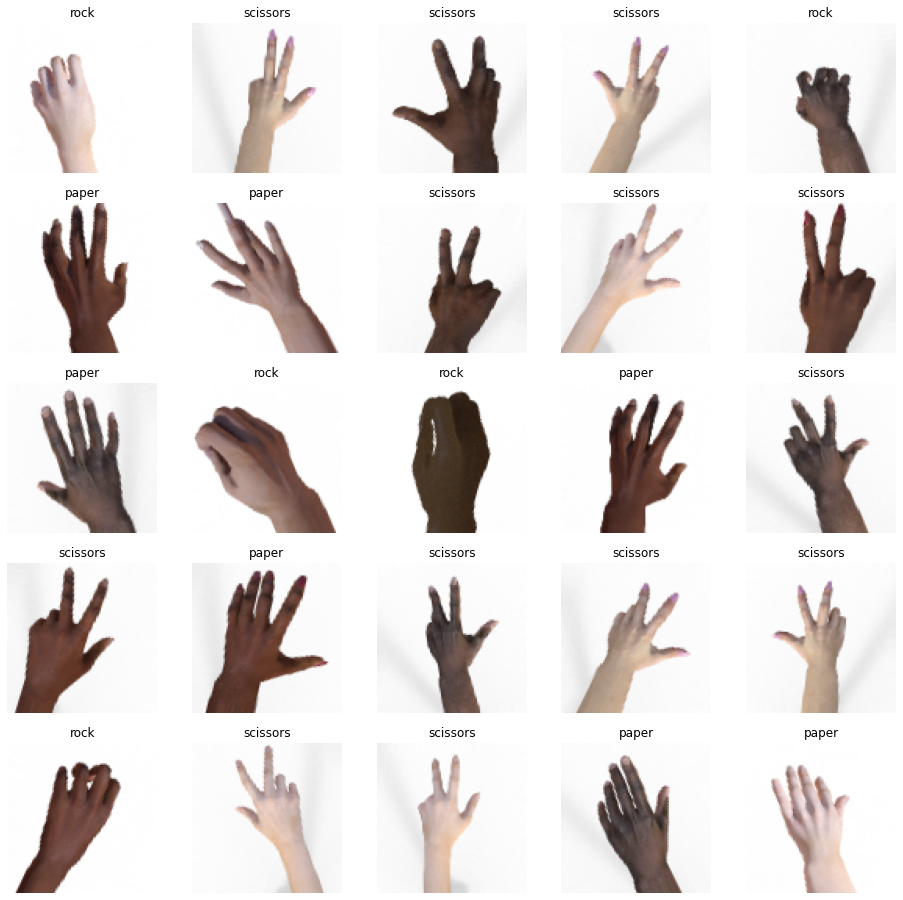

In [106]:
plt.figure(figsize=(16, 16))

for i in range(25):
    plt.subplot(5, 5, i+1)
    img, label = sample_data.next()
    plt.imshow(img[0])
    plt.title(CLASS_NAMES[label[0].argmax()])
    plt.axis('off')

plt.show()

### Model Generation

In [107]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def get_model_1(img_shape: tuple):
    inputs = tf.keras. Input(shape=img_shape)
    # Conv Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Conv Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Conv Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Conv Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Conv Block 4
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    #flatten
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    output = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

    

In [108]:
sample_generator_conf = {
    "horizontal_flip": True,
    "rotation_range": 30,
    # "height_shift_range": 0.1,
    # "width_shift_range": 0.1,
    "zoom_range": 0.1
}


sample_img_conf = {
    "target_size": (96, 96),
    "color_mode": "grayscale",
    "batch_size": 128,
}

train_images, val_images, test_images = get_datasets(DATASET_PATH, sample_generator_conf, sample_img_conf, val_split=0.7, seed=1, get_test_set=True)

Found 2520 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


In [109]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

px = sample_img_conf["target_size"]
chanels = 1 if sample_img_conf["color_mode"] == "grayscale" else 3

model = get_model_1((*px, chanels))
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 96, 96, 32)        320       
                                                                 
 conv2d_99 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_49 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 48, 48, 64)        184

In [110]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [111]:
history = model.fit(train_images, epochs=50, validation_data=val_images, callbacks=[es])

Epoch 1/50


2022-06-06 14:28:22.372106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.6984

2022-06-06 14:28:34.177992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 13s 573ms/step - loss: 0.6789 - accuracy: 0.6984 - val_loss: 1.3699 - val_accuracy: 0.3333
Epoch 2/50
20/20 [==============================] - 9s 443ms/step - loss: 0.0988 - accuracy: 0.9694 - val_loss: 4.6300 - val_accuracy: 0.3333
Epoch 3/50
 1/20 [>.............................] - ETA: 14s - loss: 0.0516 - accuracy: 0.9922

KeyboardInterrupt: 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

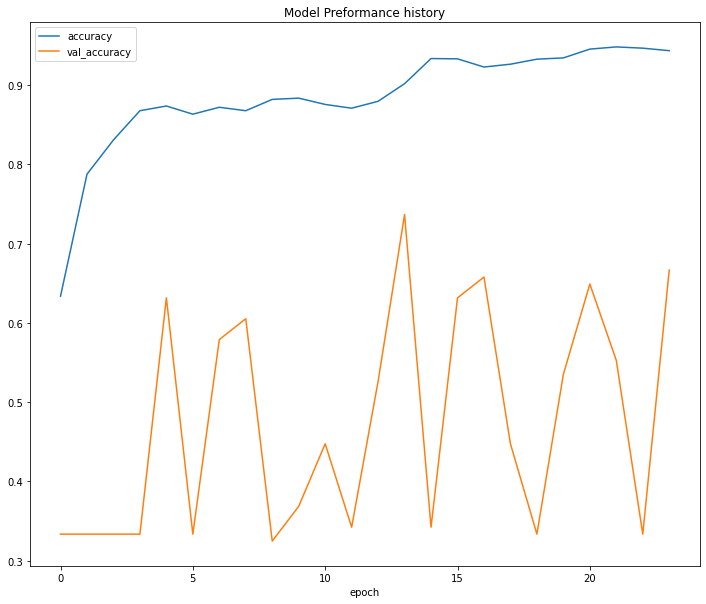

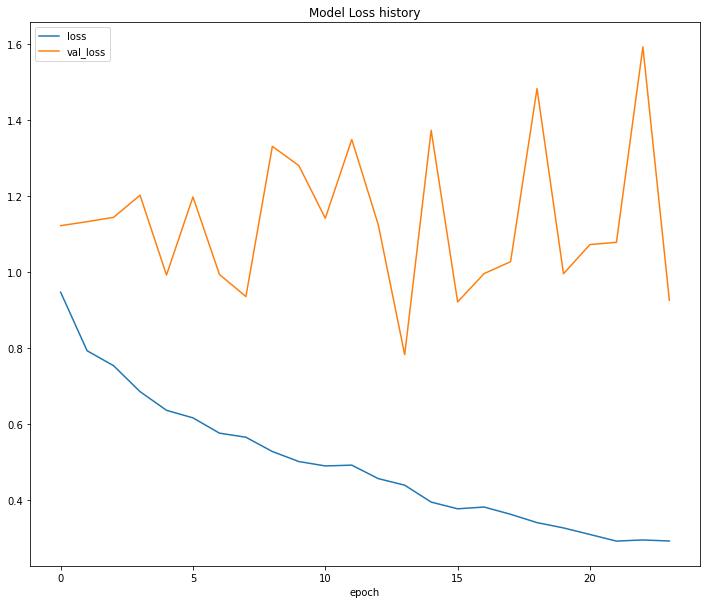

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_val_accuracy'])
    
plt.title('Model Preformance history')
plt.xlabel('epoch')
plt.legend(["sparse_categorical_accuracy", "sparse_categorical_val_accuracy"], loc='upper left')


plt.figure(figsize=(12,10))
plt.plot(history.history['sparse_categorical_loss'])
plt.plot(history.history['sparse_categorical_val_loss'])
    
plt.title('Model Loss sparse_categorical_history')
plt.xlabel('epoch')
plt.legend(["sparse_categorical_loss", "sparse_categorical_val_loss"], loc='upper left')

plt.show()

In [ ]:
model.evaluate(test_images)

5/5 [==============================] - 1s 173ms/step - loss: 1.0101 - accuracy: 0.6395


[1.0100733041763306, 0.6395348906517029]